### Part 2, Cont.: Analyze Wetland Site Priorities (100)

#### 6a. Establish Randomized Weighting

In [55]:
import arcpy
import random
from arcpy import env
from arcpy.sa import *

# Set environment settings
arcpy.env.scratchWorkspace = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\RandWeights_100.gdb"
arcpy.env.workspace = arcpy.env.scratchWorkspace

# Define the file paths for input rasters
nwi_buffer = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\NWI_Buffer500m_Raster"
soils_reclass = r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped\soils_reclass"
twi_reclass = r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped\TWI_reclass"
slope_reclass = r"C:\Users\ethan\Desktop\ARLT_MGIS\GIS5571\FinalProject\Data\Clipped\Slope_Reclass"
agveg_reclass = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\AgVeg_Reclass"
imperv_reclass = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\Imperv_Reclass"

# Create a new table to track weights and iteration numbers
tracking_table = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\RandWeights_100.gdb\WeightTrackingTable"

# Check if the table exists, and create it if it doesn't
if not arcpy.Exists(tracking_table):
    arcpy.CreateTable_management(arcpy.env.workspace, "WeightTrackingTable")
    arcpy.AddField_management(tracking_table, "Iteration", "LONG")
    arcpy.AddField_management(tracking_table, "NWI_Weight", "DOUBLE")
    arcpy.AddField_management(tracking_table, "Soils_Weight", "DOUBLE")
    arcpy.AddField_management(tracking_table, "TWI_Weight", "DOUBLE")
    arcpy.AddField_management(tracking_table, "Slope_Weight", "DOUBLE")
    arcpy.AddField_management(tracking_table, "AgVeg_Weight", "DOUBLE")
    arcpy.AddField_management(tracking_table, "Imperv_Weight", "DOUBLE")

# Function to generate random weights that sum to 100 with each weight >= 1
def generate_scaled_weights():
    # Generate random values
    random_weights = [random.randint(1, 10) for _ in range(6)]
    
    # Calculate the sum of random weights
    total_weight = sum(random_weights)
    
    # Scale the weights so that they sum to 100
    scaled_weights = [int((weight / total_weight) * 100) for weight in random_weights]
    
    # If the scaling caused any rounding error (i.e., sum is not exactly 100), adjust the first value
    correction = 100 - sum(scaled_weights)
    scaled_weights[0] += correction  # Apply the correction to the first weight
    
    return scaled_weights

# Run the random iterations
for i in range(100):
    # Generate random weights that sum to 100
    weights = generate_scaled_weights()

    # Multiply each raster by its corresponding weight and normalize (keep integer range between 1-10)
    weighted_nwi = Raster(nwi_buffer) * (weights[0] / 100.0)
    weighted_soils = Raster(soils_reclass) * (weights[1] / 100.0)
    weighted_twi = Raster(twi_reclass) * (weights[2] / 100.0)
    weighted_slope = Raster(slope_reclass) * (weights[3] / 100.0)
    weighted_agveg = Raster(agveg_reclass) * (weights[4] / 100.0)
    weighted_imperv = Raster(imperv_reclass) * (weights[5] / 100.0)

    # Sum all weighted rasters
    final_sum = weighted_nwi + weighted_soils + weighted_twi + weighted_slope + weighted_agveg + weighted_imperv

    # Scale the sum to ensure values fall within the range 1–10
    final_sum_scaled = final_sum * 10.0  # To adjust the scale properly for the desired range

    # Normalize the final sum to be in the range of 1-10 (ensure integer values)
    final_raster = Con(final_sum_scaled <= 0, 1, 
                       Con(final_sum_scaled >= 10, 10, Int(final_sum_scaled)))

    # Save the output with a unique name for each iteration
    out_raster_path = rf"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\RandWeights_100.gdb\Raster_Iteration_{i}"
    final_raster.save(out_raster_path)

    # Add a record to the WeightTrackingTable for the current iteration and its weights
    cursor = arcpy.da.InsertCursor(tracking_table, ["Iteration", "NWI_Weight", "Soils_Weight", "TWI_Weight", "Slope_Weight", "AgVeg_Weight", "Imperv_Weight"])
    cursor.insertRow([i, weights[0], weights[1], weights[2], weights[3], weights[4], weights[5]])

    # Create attribute table for the final raster if it doesn't exist
    if not arcpy.ListFields(out_raster_path):
        arcpy.management.BuildRasterAttributeTable(out_raster_path, "OVERWRITE")
        
    print(f"Iteration {i + 1} completed with weights: {weights}")

Iteration 1 completed with weights: [5, 50, 5, 20, 5, 15]
Iteration 2 completed with weights: [13, 21, 18, 3, 27, 18]
Iteration 3 completed with weights: [20, 3, 28, 12, 6, 31]
Iteration 4 completed with weights: [9, 32, 16, 22, 12, 9]
Iteration 5 completed with weights: [26, 23, 13, 2, 13, 23]
Iteration 6 completed with weights: [16, 26, 18, 7, 26, 7]
Iteration 7 completed with weights: [31, 6, 15, 6, 24, 18]
Iteration 8 completed with weights: [25, 27, 16, 5, 22, 5]
Iteration 9 completed with weights: [32, 13, 4, 17, 17, 17]
Iteration 10 completed with weights: [25, 15, 15, 15, 23, 7]
Iteration 11 completed with weights: [29, 13, 6, 23, 6, 23]
Iteration 12 completed with weights: [28, 5, 11, 13, 16, 27]
Iteration 13 completed with weights: [16, 31, 9, 13, 27, 4]
Iteration 14 completed with weights: [10, 20, 30, 10, 20, 10]
Iteration 15 completed with weights: [29, 23, 3, 26, 16, 3]
Iteration 16 completed with weights: [26, 25, 22, 2, 15, 10]
Iteration 17 completed with weights: [20, 

#### 6b. Compare to Non-Randomized Weighting (Equal Weighting)

In [56]:
# Calculate the T-Statistics and P-Value of the Random Weighting Rasters

import arcpy
import pandas as pd
import numpy as np
import os
from scipy.stats import ttest_rel

# Set environment
arcpy.env.workspace = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\RandWeights_100.gdb"
arcpy.env.overwriteOutput = True

# Paths
equal_raster_path = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\WtOv_Equal_t2"
weight_table_path = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\RandWeights_100.gdb\WeightTrackingTable"
output_folder = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Outputs"

# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Load weight tracking table
weight_table = arcpy.da.TableToNumPyArray(weight_table_path, ['OBJECTID', 'Iteration', 'NWI_Weight', 'Soils_Weight', 'TWI_Weight', 'Slope_Weight', 'AgVeg_Weight', 'Imperv_Weight'])

# Create a dictionary for random weights using Iteration as the key
random_weights = {f"Raster_Iteration_{row['Iteration']}": row.tolist()[2:] for row in weight_table}

# Convert weights to DataFrame for reference
weights_df = pd.DataFrame(weight_table, columns=['OBJECTID', 'Iteration', 'NWI_Weight', 'Soils_Weight', 'TWI_Weight', 'Slope_Weight', 'AgVeg_Weight', 'Imperv_Weight'])

# Print the DataFrame to check the values
print(weights_df)

# Placeholder for summary statistics
summary_stats = []

# Load the equal-weight raster
equal_raster = arcpy.RasterToNumPyArray(equal_raster_path)

# Process each random-weight raster
for raster_path, weights in random_weights.items():
    print(f"Processing: {raster_path}")
    random_raster_path = os.path.join(arcpy.env.workspace, raster_path)
    
    # Load random raster
    random_raster = arcpy.RasterToNumPyArray(random_raster_path)
    
    # Compute statistics
    mean_val = np.nanmean(random_raster)
    std_val = np.nanstd(random_raster)
    
    # Store statistics
    summary_stats.append([raster_path, weights, mean_val, std_val])
    
    # Calculate and save the difference raster
    diff_raster = arcpy.Raster(random_raster_path) - arcpy.Raster(equal_raster_path)
    diff_raster.save(os.path.join(output_folder, f"{raster_path}_difference.tif"))

# Convert summary statistics to a DataFrame
df = pd.DataFrame(summary_stats, columns=["Raster", "Weights", "Mean", "Std"])
df.to_csv(os.path.join(output_folder, "weighted_raster_summary.csv"), index=False)

# Perform paired t-test between equal-weight and random-weight means
equal_mean = np.nanmean(equal_raster)
random_means = df["Mean"].values

t_stat, p_val = ttest_rel([equal_mean] * len(random_means), random_means)
print(f"T-Statistic: {t_stat}, P-Value: {p_val}")

# Save t-test result to a file
with open(os.path.join(output_folder, "t_test_results.txt"), "w") as f:
    f.write(f"T-Statistic: {t_stat}\nP-Value: {p_val}\n")

print("Processing complete!")

    OBJECTID  Iteration  NWI_Weight  ...  Slope_Weight  AgVeg_Weight  Imperv_Weight
0          1          0         5.0  ...          20.0           5.0           15.0
1          2          1        13.0  ...           3.0          27.0           18.0
2          3          2        20.0  ...          12.0           6.0           31.0
3          4          3         9.0  ...          22.0          12.0            9.0
4          5          4        26.0  ...           2.0          13.0           23.0
..       ...        ...         ...  ...           ...           ...            ...
94        95         94        11.0  ...          10.0          23.0           23.0
95        96         95        10.0  ...          11.0          52.0            5.0
96        97         96        16.0  ...          15.0          22.0           20.0
97        98         97        19.0  ...          18.0          18.0           15.0
98        99         98         8.0  ...          12.0          25.0        

#### 6c. Plot the value distribution for random weights with equal weight.

In [75]:
# Plot the Histogram of the Random Weighting Rasters

import arcpy
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Set environment
arcpy.env.workspace = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\RandWeights_100.gdb"
arcpy.env.overwriteOutput = True

# Paths
equal_raster_path = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\WtOv_Equal_t2"
weight_table_path = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\RandWeights_100.gdb\WeightTrackingTable"

# Load weight tracking table
weight_table = arcpy.da.TableToNumPyArray(weight_table_path, ['OBJECTID', 'Iteration', 'NWI_Weight', 'Soils_Weight', 'TWI_Weight', 'Slope_Weight', 'AgVeg_Weight', 'Imperv_Weight'])

# Create a dictionary for random weights using Iteration as the key
random_weights = {f"Raster_Iteration_{row['Iteration']}": row.tolist()[2:] for row in weight_table}

# Placeholder for summary statistics and plot data
iterations = []
equal_values = []
random_values = []

# Load the equal-weight raster
equal_raster = arcpy.RasterToNumPyArray(equal_raster_path)

# Process each random-weight raster and collect data for plotting
for raster_path, weights in random_weights.items():
    print(f"Processing: {raster_path}")
    
    # Load random raster as NumPy array
    random_raster_path = os.path.join(arcpy.env.workspace, raster_path)
    random_raster = arcpy.RasterToNumPyArray(random_raster_path)
    
    # Store iteration, equal raster values, and random raster values
    iterations.append(raster_path)
    equal_values.append(equal_raster.flatten())  # Flatten to make it 1D
    random_values.append(random_raster.flatten())  # Flatten to make it 1D

# Create a figure for the histograms
plt.figure(figsize=(12, 8))

# Plot the equal-weight raster histogram in a distinct color (e.g., blue)
plt.hist(equal_values[0], bins=30, color='blue', alpha=0.8, label="Equal Weight Raster")

# Plot the histograms for the random-weight rasters in a single color (e.g., gray)
for i, random_vals in enumerate(random_values):
    plt.hist(random_vals, bins=30, color='gray', alpha=0.4, label="Random Weight Rasters" if i == 0 else None)  # Label only once

# Customize the plot
plt.title("Distribution of Raster Values: Equal Weight vs Random Weight Iterations")
plt.xlabel("Raster Value")
plt.ylabel("Frequency")

# Add a legend next to the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=10, title="Legend", frameon=True)

# Adjust layout to make room for the legend
plt.tight_layout()

# Show the plot
plt.show()

Processing: Raster_Iteration_0
Processing: Raster_Iteration_1
Processing: Raster_Iteration_2
Processing: Raster_Iteration_3
Processing: Raster_Iteration_4
Processing: Raster_Iteration_5
Processing: Raster_Iteration_6
Processing: Raster_Iteration_7
Processing: Raster_Iteration_8
Processing: Raster_Iteration_9
Processing: Raster_Iteration_10
Processing: Raster_Iteration_11
Processing: Raster_Iteration_12
Processing: Raster_Iteration_13
Processing: Raster_Iteration_14
Processing: Raster_Iteration_15
Processing: Raster_Iteration_16
Processing: Raster_Iteration_17
Processing: Raster_Iteration_18
Processing: Raster_Iteration_19
Processing: Raster_Iteration_20
Processing: Raster_Iteration_21
Processing: Raster_Iteration_22
Processing: Raster_Iteration_23
Processing: Raster_Iteration_24
Processing: Raster_Iteration_25
Processing: Raster_Iteration_26
Processing: Raster_Iteration_27
Processing: Raster_Iteration_28
Processing: Raster_Iteration_29
Processing: Raster_Iteration_30
Processing: Raster

#### 6d. Compare RMSE, R2 Values for Random vs Equal Weight

RMSE: min=0.9285, max=2.9021, mean=1.6053
R^2: min=-2.0226, max=0.6906, mean=0.0244


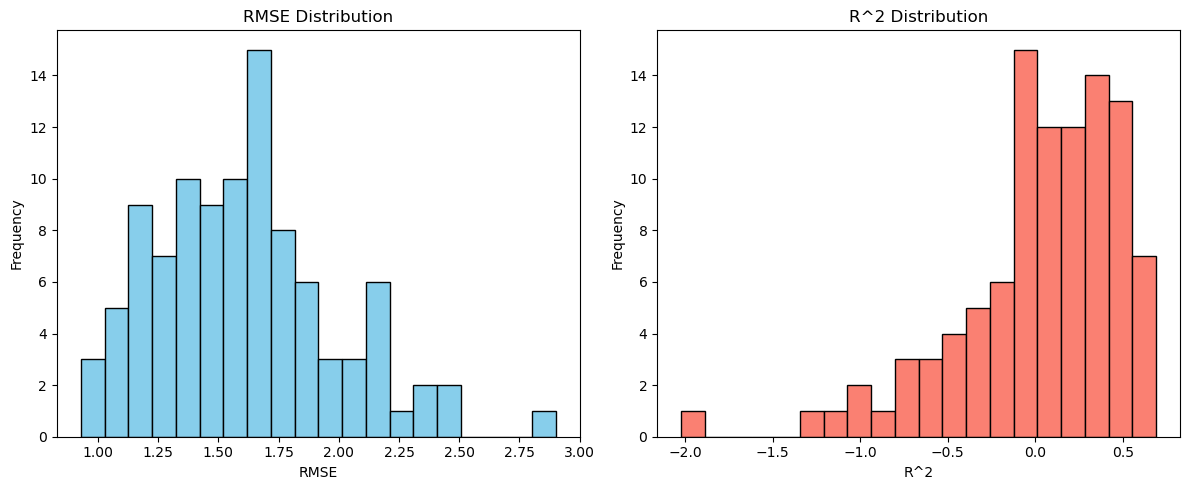

In [59]:
# Plot the information compared to Equal Weights

import arcpy
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Set environment settings
arcpy.env.workspace = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\RandWeights_100.gdb"
arcpy.env.overwriteOutput = True

# Load the equal-weight raster as a NumPy array
equal_raster = arcpy.RasterToNumPyArray(r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\WtOv_Equal_t2")

# List all rasters in the RandWeights_100.gdb workspace
random_weight_rasters = arcpy.ListRasters()

if not random_weight_rasters:
    raise ValueError("No rasters found in the workspace.")

# Placeholder for results
rmse_values = []
r2_values = []

# Iterate through the randomly weighted rasters
for raster_name in random_weight_rasters:
    raster_path = f"{arcpy.env.workspace}\\{raster_name}"  # Construct full path
    # Convert raster to NumPy array
    random_raster = arcpy.RasterToNumPyArray(raster_path)

    # Ensure both rasters are aligned in terms of dimensions
    if equal_raster.shape != random_raster.shape:
        raise ValueError(f"Raster dimensions do not match for {raster_path}")

    # Flatten the arrays for metric calculations
    equal_flat = equal_raster.flatten()
    random_flat = random_raster.flatten()

    # Compute RMSE
    rmse = np.sqrt(mean_squared_error(equal_flat, random_flat))
    rmse_values.append(rmse)

    # Compute R^2
    r2 = r2_score(equal_flat, random_flat)
    r2_values.append(r2)

# Print summary statistics
print(f"RMSE: min={np.min(rmse_values):.4f}, max={np.max(rmse_values):.4f}, mean={np.mean(rmse_values):.4f}")
print(f"R^2: min={np.min(r2_values):.4f}, max={np.max(r2_values):.4f}, mean={np.mean(r2_values):.4f}")

# Optional: Visualize RMSE and R^2 distributions
plt.figure(figsize=(12, 5))

# RMSE histogram
plt.subplot(1, 2, 1)
plt.hist(rmse_values, bins=20, color='skyblue', edgecolor='black')
plt.title("RMSE Distribution")
plt.xlabel("RMSE")
plt.ylabel("Frequency")

# R^2 histogram
plt.subplot(1, 2, 2)
plt.hist(r2_values, bins=20, color='salmon', edgecolor='black')
plt.title("R^2 Distribution")
plt.xlabel("R^2")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


#### 6e. Compare Getis-Ord Gi* Scores for Random Weights

#### Attempt 1

In [2]:
# G Scores Applied to Random Weight Rasters

import arcpy
import numpy as np
import matplotlib.pyplot as plt
import os

# Set environment settings
arcpy.env.workspace = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\RandWeights_100.gdb"
arcpy.env.overwriteOutput = True

# Load the equal-weight raster as a NumPy array
equal_raster = arcpy.RasterToNumPyArray(r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\WtOv_Equal_t2")

# List all rasters in the RandWeights_100.gdb workspace
random_weight_rasters = arcpy.ListRasters()

if not random_weight_rasters:
    raise ValueError("No rasters found in the workspace.")

# Function to load raster data
def load_raster(raster_name):
    # Load raster using arcpy
    raster = arcpy.Raster(raster_name)
    # Convert raster to numpy array
    raster_array = arcpy.RasterToNumPyArray(raster)
    return raster_array

# Function to calculate the Getis-Ord Gi* statistic manually
def compute_gi_star(raster_array, window_size=3):
    # Initialize variables to hold Gi* results
    gi_star_array = np.full(raster_array.shape, np.nan, dtype=float)
    half_window = window_size // 2
    
    # Iterate over the raster, ignoring the edges (based on window size)
    for row in range(half_window, raster_array.shape[0] - half_window):
        for col in range(half_window, raster_array.shape[1] - half_window):
            # Extract the window of values
            window = raster_array[row-half_window:row+half_window+1, col-half_window:col+half_window+1]
            
            # Calculate the mean and standard deviation of the window
            window_mean = np.mean(window)
            window_std = np.std(window)
            
            # If standard deviation is zero, set Gi* to NaN
            if window_std == 0:
                continue
            
            # Calculate the Getis-Ord Gi* score for the central cell
            numerator = np.sum(window - window_mean)  # Sum of deviations from mean
            denominator = window_std * len(window.flatten())  # Standard deviation * number of cells
            
            # Store the Gi* score for the central cell
            gi_star_array[row, col] = numerator / denominator
    
    return gi_star_array


# Initialize a list to store Gi* results for each raster
gi_star_results = []

# Loop over each raster file and compute Gi*
for raster_name in random_weight_rasters:
    # Load raster as NumPy array
    raster_data = load_raster(raster_name)
    
    # Compute Gi* for the raster manually
    gi_star = compute_gi_star(raster_data)
    
    # Store the Gi* Z-scores (flattened, ignoring NaN)
    gi_star_results.append(gi_star.flatten())

# Convert the list of Gi* results into a NumPy array for easier analysis
gi_star_array = np.array(gi_star_results)

# Plot the Gi* Z-scores for each raster (histograms)
plt.figure(figsize=(10, 6))

for i, gi_scores in enumerate(gi_star_results):
    plt.hist(gi_scores[~np.isnan(gi_scores)], bins=20, alpha=0.5, label=f"Raster {i+1}")

plt.title('Getis-Ord Gi* Z-scores for Multiple Rasters')
plt.xlabel('Gi* Z-score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Calculate summary statistics for all Gi* Z-scores
mean_gi_star = [np.nanmean(scores) for scores in gi_star_results]
std_gi_star = [np.nanstd(scores) for scores in gi_star_results]

# Print mean and standard deviation of Gi* Z-scores for each raster
for i, (mean, std) in enumerate(zip(mean_gi_star, std_gi_star)):
    print(f"Raster {i+1} - Mean Gi* Z-score: {mean:.4f}, Standard Deviation: {std:.4f}")

KeyboardInterrupt: 

#### Attempt 2

In [3]:
import arcpy
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter

# Function to compute Gi* using optimized convolution
def compute_gi_star_optimized(raster_array, window_size=3):
    # Convert to float for precision
    raster_array = raster_array.astype(np.float64)
    
    # Check for constant or invalid raster values
    if np.all(raster_array == raster_array[0]):
        print("Raster contains constant values; skipping computation.")
        return np.zeros_like(raster_array, dtype=float)
    
    n_cells = window_size ** 2
    local_mean = uniform_filter(raster_array, size=window_size, mode='constant', cval=0)
    local_squared_mean = uniform_filter(raster_array**2, size=window_size, mode='constant', cval=0)
    local_std = np.sqrt(local_squared_mean - local_mean**2)
    
    numerator = uniform_filter(raster_array, size=window_size, mode='constant', cval=0) * n_cells - local_mean * n_cells
    denominator = local_std * n_cells
    
    # Handle division by zero
    denominator[local_std == 0] = np.nan
    
    with np.errstate(divide='ignore', invalid='ignore'):
        gi_star = np.divide(numerator, denominator)
        gi_star[np.isnan(gi_star)] = 0  # Replace NaN with 0 for stability
    
    return gi_star

# Set environment settings
arcpy.env.workspace = r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\RandWeights_100.gdb"
arcpy.env.overwriteOutput = True

# Load the equal-weight raster as a NumPy array
equal_raster = arcpy.RasterToNumPyArray(r"C:\Users\ethan\Documents\ArcGIS\Projects\Arc1_FinalProject\Arc1_FinalProject.gdb\WtOv_Equal_t2")

# List all rasters in the RandWeights_100.gdb workspace
random_weight_rasters = arcpy.ListRasters()

if not random_weight_rasters:
    raise ValueError("No rasters found in the workspace.")

# Initialize a list to store Gi* results for each raster
gi_star_results = []

# Loop over each raster file and compute Gi*
for raster_name in random_weight_rasters:
    print(f"Processing {raster_name}")
    
    # Load raster as NumPy array
    raster_data = arcpy.RasterToNumPyArray(raster_name)
    
    # Compute Gi* using the optimized method
    gi_star = compute_gi_star_optimized(raster_data)
    
    # Store the Gi* Z-scores (flattened)
    gi_star_results.append(gi_star.flatten())

# Plot the Gi* Z-scores for each raster (histograms)
plt.figure(figsize=(10, 6))

for i, gi_scores in enumerate(gi_star_results):
    plt.hist(gi_scores, bins=20, alpha=0.5, label=f"Raster {i+1}")

plt.title('Getis-Ord Gi* Z-scores for Multiple Rasters')
plt.xlabel('Gi* Z-score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Calculate summary statistics for all Gi* Z-scores
mean_gi_star = [np.nanmean(scores) for scores in gi_star_results]
std_gi_star = [np.nanstd(scores) for scores in gi_star_results]

# Print mean and standard deviation of Gi* Z-scores for each raster
for i, (mean, std) in enumerate(zip(mean_gi_star, std_gi_star)):
    print(f"Raster {i+1} - Mean Gi* Z-score: {mean:.4f}, Standard Deviation: {std:.4f}")

Processing Raster_Iteration_0


[3]:19: RuntimeWarning: invalid value encountered in sqrt


Processing Raster_Iteration_1
Processing Raster_Iteration_2
Processing Raster_Iteration_3
Processing Raster_Iteration_4
Processing Raster_Iteration_5
Processing Raster_Iteration_6
Processing Raster_Iteration_7
Processing Raster_Iteration_8
Processing Raster_Iteration_9
Processing Raster_Iteration_10
Processing Raster_Iteration_11
Processing Raster_Iteration_12
Processing Raster_Iteration_13
Processing Raster_Iteration_14
Processing Raster_Iteration_15
Processing Raster_Iteration_16
Processing Raster_Iteration_17
Processing Raster_Iteration_18
Processing Raster_Iteration_19
Processing Raster_Iteration_20
Processing Raster_Iteration_21
Processing Raster_Iteration_22
Processing Raster_Iteration_23
Processing Raster_Iteration_24
Processing Raster_Iteration_25
Processing Raster_Iteration_26
Processing Raster_Iteration_27
Processing Raster_Iteration_28
Processing Raster_Iteration_29
Processing Raster_Iteration_30
Processing Raster_Iteration_31
Processing Raster_Iteration_32
Processing Raster